# **Setup**

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [142]:
import pandas as pd
import os
import re
import ast

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
#!pip install openai==1.55.3 httpx==0.27.2 --force-reinstall --quiet
import openai
api_key = "fake_key"
openai.api_key = api_key

# **Call Functions**

In [ ]:
# Define the function to evaluate the text with a prompt
def evaluate_text_with_prompt(text, prompt, model="gpt-4-turbo"):
#def evaluate_text_with_prompt(text, prompt, model="o1"):
    response = openai.chat.completions.create(
        model=model,
        messages=[
            {"role": "system", "content": "Você é um avaliador expert"},
            {"role": "user", "content": prompt},
            {"role": "user", "content": text}
        ]
    )
    return response.choices[0].message.content

# Call Topics

In [5]:
#Import topics
file_path = "/content/drive/MyDrive/Portfolio Projects/Mestrado/Temp/df_topicos_qna.csv"

df = pd.read_csv(file_path)
df['topicos'] = df['topicos'].apply(lambda x: ast.literal_eval(x))
df.head()

,index,doc,response,Tarefa 1,Tarefa 2,topicos
0,0,prbc-2012-1,"Desculpe, mas parece que faltou incluir o text...",NaN,NaN,[]
1,0,bmgb-2022-2,Tarefa 1:\n- Dinâmica da margem financeira\n- ...,- Dinâmica da margem financeira- Crescimento d...,positivo,"[Dinâmica da margem financeira, Crescimento da..."
2,0,brsr-2013-4,Tarefa 1:\n- Crescimento do Banricompras\n- Ex...,- Crescimento do Banricompras- Expansão do Ban...,positivo,"[Crescimento do Banricompras, Expansão do Banr..."
3,0,abcb-2022-3,Tarefa 1:\n- Resultados financeiros trimestrai...,- Resultados financeiros trimestrais- ROE reco...,positivo,"[Resultados financeiros trimestrais, ROE recor..."
4,0,brsr-2007-4,Tarefa 1:\n- Resultados financeiros Banrisul 2...,- Resultados financeiros Banrisul 2007- Cresci...,positivo,"[Resultados financeiros Banrisul 2007, Crescim..."


## Standardize Topics

In [6]:
#Transform into list of topics for chatGPT
topics_list = []
for index, row in df.iterrows():
  for topic in row['topicos']:
    topics_list.append(topic)
topics_set = {topic for topic in topics_list}

# Remove backslashes from each element and join into a single string
topics_str = ', '.join(s.replace("\\", "") for s in topics_set)

In [ ]:
prompt = """
      O texto representa uma lista com tópicos referentes a documentos de apresentação de resultados para cada banco, ano e trimestre.
      Existem vários tópicos que significam a mesma coisa, mas tem nomes diferentes. Você poderia padronizar os textos dos tópicos para que eu possa verificar a evolução dos tópicos ao decorrer do tempo?

      A resposta deve vir num formato de dicionário que inclua o tópico original e o tópico final no seguinte formato:
      {'tópico_original' : 'tópico_final'}
"""

response = evaluate_text_with_prompt(topics_str, prompt) #evaluate_text_with_prompt(before_text, prompt)
print(response)

A padronização de tópicos do setor bancário e financeiro pode ser complexa devido à variedade de termos utilizados para descrever conceitos semelhantes. Vou padronizar alguns tópicos baseando-me em temas comuns. Aqui estão exemplos de como tópicos variados podem ser uniformizados:

```json
{
  "Inadimplência na carteira Middle": "Inadimplência de Carteiras",
  "Temas de inadimplência": "Inadimplência de Carteiras",
  "Inadimplência corporativa e sazonalidade": "Inadimplência de Carteiras",
  "Inadimplência e índice de eficiência": "Inadimplência de Carteiras",
  "Inadimplência e estratégias de melhoria": "Inadimplência de Carteiras",
  "Margem financeira e reprecificação da carteira": "Margem Financeira",
  "Margem financeira (NIM)": "Margem Financeira",
  "Expectativas para a margem financeira (NIM)": "Margem Financeira",
  "Margens financeiras": "Margem Financeira",
  "Crescimento da margem financeira": "Margem Financeira",
  "Resultados Financeiros": "Desempenho Financeiro",
  "Resu

In [ ]:
#Remodel df exploding rows
exploded_df = df.explode('topicos', ignore_index=True)[['doc','topicos']]
exploded_df['bank'] = exploded_df['doc'].apply(lambda x: x.split('-')[0])
exploded_df['year'] = exploded_df['doc'].apply(lambda x: x.split('-')[1])
exploded_df['trimester'] = exploded_df['doc'].apply(lambda x: x.split('-')[2])
exploded_df

,doc,topicos,bank,year,trimester
0,prbc-2012-1,NaN,prbc,2012,1
1,bmgb-2022-2,Dinâmica da margem financeira,bmgb,2022,2
2,bmgb-2022-2,Crescimento da carteira,bmgb,2022,2
3,bmgb-2022-2,Cartão benefício,bmgb,2022,2
4,bmgb-2022-2,Aumento dos custos administrativos,bmgb,2022,2
...,...,...,...,...,...
3631,bmgb-2021-2,Competitividade no crédito consignado,bmgb,2021,2
3632,bmgb-2021-2,Lançamento de antecipação do FGTS,bmgb,2021,2
3633,bmgb-2021-2,Pipeline de aquisições futuras,bmgb,2021,2
3634,bmgb-2021-2,Desaceleração no aumento de clientes,bmgb,2021,2


In [ ]:
#Standardize topics with topic_mapping
topic_mapping = {
    "Impacto da Selic nas Operações": "Impactos de Taxa SELIC",
    "Impacto da taxa Selic no mercado financeiro": "Impactos de Taxa SELIC",
    "Efeito da política monetária": "Impactos de Política Monetária",
    "Impacto das condições macroeconômicas": "Impactos Macroeconômicos",
    "Cenário Macroeconômico": "Impactos Macroeconômicos",
    "Condições macroeconômicas e impacto no crédito": "Impactos Macroeconômicos",
    "Questões operacionais e desenvolvimento": "Desenvolvimento Operacional e Estratégico",
    "Crescimento das transações de cartões Banricompras": "Desempenho de Segmentos de Cartões",
    "Cenário econômico desafiador": "Desafios Econômicos",
    "Provisões relativas à carteira do Banco Cruzeiro": "Provisões de Carteiras de Crédito",
    "Desempenho da carteira de crédito": "Desempenho de Carteiras de Crédito",
    "Performance da carteira de crédito": "Desempenho de Carteiras de Crédito",
    "Crédito consignado e impactos das medidas do Banco Central": "Desempenho de Crédito Consignado",
    "Análise de desempenho financeiro do Banco": "Desempenho Financeiro",
    "Crescimento de receita no setor de serviços": "Desempenho de Segmentos de Serviços",
    "Crescimento da carteira de crédito consignado": "Crescimento de Crédito Consignado",
    "Desempenho de novas safras de empréstimos": "Desempenho de Créditos",
    "Taxa de inadimplência NPL": "Índices de Inadimplência",
    "NPL ratio trends": "Tendências de Inadimplência",
    "Perspectiva de qualidade de crédito": "Qualidade de Crédito",
    "Provisões para Devedores Duvidosos (PDD)": "Provisões para Inadimplência",
    "Melhora da margem financeira": "Melhoria da Margem Financeira",
    "Rendimento de equalização": "Margens e Rendimentos",
    "Crescimento da margem financeira": "Crescimento da Margem Financeira",
    "Desempenho da margem financeira na América Latina": "Desempenho Regional da Margem Financeira",
    "Operação de crédito consignado": "Operações de Crédito Consignado",
    "Projeção de crescimento de crédito": "Projeções de Crescimento de Crédito",
    "Previsão de inadimplência futura": "Previsões de Inadimplência",
    "Tendência de crescimento da carteira de crédito": "Tendências de Crescimento de Crédito",
    "Estratégias de crescimento": "Estratégias de Crescimento Organizacional",
    "Impacto das políticas do Banco Central": "Impacto de Políticas Regulatórias",
    "Impacto das regras de Basileia 3": "Impactos de Regulamentações de Basileia",
    "Impacto das pequenas empresas na carteira SME": "Impacto nos Segmentos de Pequenas e Médias Empresas",
    "Impacto da política macroeconômica": "Impactos Político-Econômicos",
    "Inovação em modelos de negócios": "Inovações em Modelos de Negócios",
    "Impacto da reforma da previdência em impostos": "Impactos de Reformas Previdenciárias",

    "Inadimplência na carteira Middle": "Inadimplência de Carteiras",
    "Temas de inadimplência": "Inadimplência de Carteiras",
    "Inadimplência corporativa e sazonalidade": "Inadimplência de Carteiras",
    "Inadimplência e índice de eficiência": "Inadimplência de Carteiras",
    "Inadimplência e estratégias de melhoria": "Inadimplência de Carteiras",
    "Margem financeira e reprecificação da carteira": "Margem Financeira",
    "Margem financeira (NIM)": "Margem Financeira",
    "Expectativas para a margem financeira (NIM)": "Margem Financeira",
    "Margens financeiras": "Margem Financeira",
    "Crescimento da margem financeira": "Margem Financeira",
    "Resultados Financeiros": "Desempenho Financeiro",
    "Resultado de tesouraria 1T13": "Desempenho Financeiro",
    "Resultados financeiros de 2022": "Desempenho Financeiro",
    "Desempenho trimestral do Banco": "Desempenho Financeiro",
    "Resultados financeiros Santander Brasil": "Desempenho Financeiro",
    "Estratégia de crescimento do Banco": "Estratégias de Crescimento",
    "Estratégia de crescimento orgânico e inorgânico": "Estratégias de Crescimento",
    "Provisões e cobertura de risco": "Provisões e Gestão de Riscos",
    "Provisões e gestão de riscos": "Provisões e Gestão de Riscos",
    "Provisões": "Provisões e Gestão de Riscos",
    "Provisão de crédito": "Provisões e Gestão de Riscos",
    "Política de provisão de crédito": "Provisões e Gestão de Riscos",

    "Inadimplência na carteira Middle": "Inadimplência",
    "Inadimplência e recuperação de créditos": "Inadimplência",
    "Inadimplência corporativa e sazonalidade": "Inadimplência",
    "Temas de inadimplência": "Inadimplência",
    "Qualidade da carteira de crédito": "Qualidade de crédito",
    "Qualidade de carteira de crédito": "Qualidade de crédito",
    "Qualidade dos ativos": "Qualidade de crédito",
    "Qualidade e diversificação do portfólio": "Qualidade de crédito",
    "Níveis de spread bancário": "Spread bancário",
    "Impacto do spread financeiro e de risco": "Spread bancário",
    "Spread por produto": "Spread bancário",
    "Margem financeira e spreads": "Spread bancário",
    "Margem financeira (NIM)": "Margem financeira",
    "Tendência do NIM (Net Interest Margin)": "Margem financeira",
    "Expectativas para a margem financeira (NIM)": "Margem financeira",
    "Performance da margem financeira com clientes": "Margem financeira",
    "Crescimento da carteira": "Crescimento da carteira",
    "Crescimento da carteira de crédito": "Crescimento da carteira",
    "Tendência de crescimento da carteira de crédito": "Crescimento da carteira",
    "Crescimento da carteira PF": "Crescimento da carteira",
    "Projeção de lucro 2023 e 2024": "Projeção de lucro",
    "Guidance de lucro líquido": "Projeção de lucro",
    "Projeções futuras de lucros ajustados": "Projeção de lucro",
    "Retorno sobre o capital (ROAE)": "Rentabilidade",
    "ROE (Retorno sobre o Patrimônio)": "Rentabilidade",
    "Rentabilidade e ROE do banco": "Rentabilidade",
    "Crescimento de transações de cartão de débito": "Cartões e transações",
    "Cartão benefício e características": "Cartões e transações",
    "Performance de cartão de crédito": "Cartões e transações",
    "Resultados financeiros de 2022": "Resultados financeiros",
    "Resultados financeiros trimestrais": "Resultados financeiros",
    "Resultados financeiros e projeções futuras": "Resultados financeiros",
    "Aumento dos custos administrativos": "Custos administrativos",
    "Gestão de custos e eficiência operacional": "Custos administrativos",
    "Manejo de custos e padronização de serviços no seguro saúde": "Custos administrativos",
    "Estratégias tributárias e alíquota de impostos": "Tributação e impostos",
    "Impactos fiscais e distribuição de JCP": "Tributação e impostos",
    "Taxa efetiva de imposto": "Tributação e impostos",
    "Programa BOMPRATODOS": "Programas governamentais",
    "Participação no Auxílio Brasil": "Programas governamentais",
    "Programas governamentais e suas influências": "Programas governamentais",
    "Captações e margem financeira": "Captação e funding",
    "Funding e estratégias de captação": "Captação e funding",
    "Captação e custo de recursos": "Captação e funding",
    "Tecnologia e transformação digital": "Digitalização",
    "Transformação digital no banco Itaú": "Digitalização",
    "Digitalização de serviços bancários": "Digitalização",
    "Originação de empréstimo para PMEs": "PMEs e crédito",
    "Créditos para pequenas e médias empresas": "PMEs e crédito",
    "Crescimento do segmento de PMEs": "PMEs e crédito"
}

exploded_df['topicos'] = exploded_df['topicos'].replace(topic_mapping)
exploded_df = exploded_df[exploded_df['topicos'] != 'Sessão de perguntas e respostas']

In [ ]:
exploded_df['topicos'] = exploded_df['topicos'].apply(lambda x: str(x).lower())
exploded_df = exploded_df[~exploded_df['topicos'].str.contains('teleconf')]
exploded_df = exploded_df[~exploded_df['topicos'].str.contains('pergunt')]

In [ ]:
exploded_df['topicos'] = exploded_df['topicos'].apply(lambda x: 'agro' if 'agro' in x else x)
exploded_df['topicos'] = exploded_df['topicos'].apply(lambda x: 'veículos' if 'veícu' in x else x)
exploded_df['topicos'] = exploded_df['topicos'].apply(lambda x: 'npl' if 'npl' in x else x)
exploded_df['topicos'] = exploded_df['topicos'].apply(lambda x: 'selic' if 'selic' in x else x)
exploded_df['topicos'] = exploded_df['topicos'].apply(lambda x: 'imobiliário' if 'imob' in x else x)
exploded_df['topicos'] = exploded_df['topicos'].apply(lambda x: 'pib' if 'pib' in x else x)
exploded_df['topicos'] = exploded_df['topicos'].apply(lambda x: 'inflação' if 'infla' in x else x)
exploded_df['topicos'] = exploded_df['topicos'].apply(lambda x: 'câmbio' if 'câmbio' in x else x)
exploded_df['topicos'] = exploded_df['topicos'].apply(lambda x: 'middle' if 'middle' in x else x)
exploded_df['topicos'] = exploded_df['topicos'].apply(lambda x: 'corporate' if 'corporate' in x else x)
exploded_df['topicos'] = exploded_df['topicos'].apply(lambda x: 'banco central' if 'banco central' in x else x)

#exploded_df[exploded_df['topicos'].str.contains('agro')]['topicos'].unique()

In [ ]:
exploded_df[exploded_df['topicos'].str.contains('inadimplência')]['topicos'].unique()

array(['inadimplência de grandes empresas',
       'dinâmica de inadimplência e cobertura', 'gestão de inadimplência',
       'tendências de inadimplência', 'impacto na inadimplência',
       'perspectivas na inadimplência pessoa jurídica',
       'inadimplência e provisões para perdas',
       'índices de inadimplência e expectativas',
       'inadimplência e sua gestão', 'inadimplência de carteiras',
       'provisões para inadimplência', 'efeitos da inadimplência',
       'evolução de inadimplência e ciclos de crédito',
       'expectativas de inadimplência para 2012',
       'explanação sobre inadimplência', 'inadimplência e custo de risco',
       'impacto de grandes empresas na inadimplência',
       'alteração nos índices de inadimplência',
       'performance de inadimplência', 'evolução da inadimplência',
       'indicadores de inadimplência', 'redução da inadimplência',
       'guidance e inadimplência',
       'questões sobre provisões para inadimplência',
       'inadimplên

In [ ]:
exploded_df.topicos.nunique()

2996

In [ ]:
exploded_df.topicos.value_counts()[30:60]

,count
topicos,
crescimento da receita de serviços,4
spread bancário,4
impacto da pandemia nas operações,4
dinâmica da margem financeira,4
margem financeira com clientes,4
crescimento de crédito,4
recuperação de crédito,4
carteira de crédito,4
receita de prestação de serviços,4


In [ ]:
exploded_df.groupby('year').agg({'topicos':'count'})

,topicos
year,
2006,10
2007,59
2008,108
2009,139
2010,185
2011,229
2012,227
2013,210
2014,169


In [ ]:
# Remove backslashes from each element and join into a single string
topics_str = ', '.join(s.replace("\\", "") for s in topics_set)
#topics_str

# **Explicit Topic Search & Sentiment Analysis**

## **ChatGPT**

In [ ]:
transcript_qna_folder = '/content/drive/MyDrive/Portfolio Projects/Mestrado/Divided_text/qna/'

files = os.listdir(transcript_qna_folder)
files = files[155:]

df_stats_2 = pd.DataFrame(columns=['doc','response'])

num_files = len(files)
for i, file in enumerate(files):
    path_transcription = transcript_qna_folder + file

    file_name_parts = file.split("-")
    ticker          = file_name_parts[0].strip()
    ano             = file_name_parts[1].strip()
    trimestre       = file_name_parts[2].strip()[0]

    print(f'Processing file {i} of {num_files}')
    print(file_name_parts)
    with open(path_transcription, 'r') as file:
      text = file.read()

      prompt = """
      Para cada um dos temas que vou listar abaixo, quero que você indique se o tema foi mencionado e se foi positivo ou negativo.

      1) Segmento agro
      2) Segmento imobiliário
      3) Segmento de veículos
      4) Middle Market
      5) Corporate
      6) Gestão de risco
      7) Inadimplência
      8) Despesas administrativas
      9) Custo de captação
      10) Provisões de Risco
      11) Taxa Selic
      12) SME
      13) Equilíbrio fiscal
      14) Medidas do governo
      15) Câmbio
      16) Cartão de crédito

      Gostaria que a resposta viesse da seguinte maneira:

      {
        'Segmento agro': ['Sim','Sim'],
        'Segmento imobiliário': ['Sim','Não'],
        'Segmento de veículos': ['Não','Não'],
        'Middle Market': ['Sim','Sim'],
        'Corporate': ['Sim','Não'],
        'Gestão de risco': ['Não','Não'],
        'Inadimplência': ['Sim','Não'],
        'Despesas administrativas': ['Sim','Não'],
        'Custo de captação': ['Sim','Não'],
        'Provisões de Risco': ['Sim','Não'],
        'Taxa Selic': ['Sim','Não'],
        'SME': ['Sim','Não'],
        'Equilíbrio fiscal': ['Sim','Não'],
        'Medidas do governo': ['Sim','Não'],
        'Câmbio': ['Sim','Não'],
        'Cartão de crédito': ['Sim','Não']

      }
    """

    response = evaluate_text_with_prompt(text, prompt)

    stats = {}
    stats['doc']              = f'{ticker}-{ano}-{trimestre}'
    stats['response']         = response

    df_stats_2 = pd.concat([df_stats_2, pd.DataFrame.from_dict([stats])])

df_stats_2.reset_index(inplace=True)

print('All files processed')

Processing file 0 of 220
['bpan', '2019', '3.txt']
Processing file 1 of 220
['brsr', '2020', '1.txt']
Processing file 2 of 220
['bbas', '2014', '4.txt']
Processing file 3 of 220
['abcb', '2009', '4.txt']
Processing file 4 of 220
['abcb', '2019', '2.txt']
Processing file 5 of 220
['itub', '2013', '4.txt']
Processing file 6 of 220
['sanb', '2013', '4.txt']
Processing file 7 of 220
['bpan', '2016', '2.txt']
Processing file 8 of 220
['prbc', '2011', '2.txt']
Processing file 9 of 220
['brsr', '2018', '1.txt']
Processing file 10 of 220
['sanb', '2012', '4.txt']
Processing file 11 of 220
['brsr', '2014', '1.txt']
Processing file 12 of 220
['bbdc', '2020', '4.txt']
Processing file 13 of 220
['abcb', '2020', '2.txt']
Processing file 14 of 220
['itub', '2014', '4.txt']
Processing file 15 of 220
['abcb', '2022', '2.txt']
Processing file 16 of 220
['sanb', '2014', '4.txt']
Processing file 17 of 220
['sanb', '2012', '3.txt']
Processing file 18 of 220
['brsr', '2012', '3.txt']
Processing file 19 of 

In [ ]:
df_merge = pd.concat([df_stats, df_stats_2])
df_merge.reset_index(inplace=True)
df_merge = df_merge.drop(['level_0','index'], axis=1)
df_merge = df_merge.drop_duplicates('doc')
df_merge['response'] = df_merge['response'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

## Checkpoint

In [ ]:
#save docs
file_path = '/content/drive/MyDrive/Portfolio Projects/Mestrado/Temp/df_topicos_qna_sentiment.csv'
df_merge.to_csv(file_path)

dict

## Call saved values

In [9]:
file_path = '/content/drive/MyDrive/Portfolio Projects/Mestrado/Temp/df_topicos_qna_sentiment.csv'
df_merge = pd.read_csv(file_path)

In [10]:
def safe_eval(x):
    try:
        return ast.literal_eval(x)
    except (ValueError, SyntaxError):
        return x

df_merge['response'] = df_merge['response'].apply(safe_eval)

In [259]:
sentiment_mapping = {'Positivo':'Sim',
                     'Negativo':'Não'}
df_gpt = pd.DataFrame(columns=['doc', 'topic', 'present', 'sentiment'])

cont = 0
total_files = 0
for index, row in df_merge.iterrows():
    total_files += 1
    doc = row['doc']
    dic = row['response']
    if isinstance(dic, str):

      dic = dic.replace('json','')
      dic = dic.replace('json','')
      dic = dic.replace('```','')
      dic = dic.replace('// SME mencionado como SMI, mas considerado como o mesmo termo','')

      dic = safe_eval(dic)

    if isinstance(dic, dict):
        for t in dic:
            topic = t
            present = dic[t][0]
            sentiment = dic[t][1]

            new_row = pd.DataFrame({'doc': [doc], 'topic': [topic], 'present': [present], 'sentiment': [sentiment]})
            df_gpt = pd.concat([df_gpt, new_row], ignore_index=True)
    else:
      cont += 1
      #print(doc, dic)
      pass

df_gpt['present'] = df_gpt['present'].apply(lambda x: 'Sim' if x == 'Sim ' else x)
df_gpt['sentiment'] = df_gpt['sentiment'].replace(sentiment_mapping)
df_gpt['bank'] = df_gpt['doc'].apply(lambda x:x.split('-')[0])
df_gpt['year'] = df_gpt['doc'].apply(lambda x:x.split('-')[1])
df_gpt['trimester'] = df_gpt['doc'].apply(lambda x:x.split('-')[2])

In [260]:
#% of Problems:
print(f'{round(cont/total_files*100,2)}%')

0.53%


In [225]:
df_gpt[df_gpt['sentiment'] == 'Neutro']

,doc,topic,present,sentiment
2617,abcb-2020-2,Provisões de Risco,Sim,Neutro
3870,sanb-2016-1,Câmbio,Sim,Neutro
4891,bbas-2019-1,SME,Sim,Neutro
4942,bbas-2009-4,Câmbio,Sim,Neutro


## **Llama**

### Call & Clean Outputs

In [136]:
transcript_qna_folder = '/content/drive/MyDrive/Portfolio Projects/Mestrado/Outputs/llama/'

files = os.listdir(transcript_qna_folder)
#files = files[0:5]

#df_info = pd.DataFrame(columns=['doc','response'])
df_info = pd.DataFrame()

problematic = ['bbas-2011-3', 'prbc-2010-2']
not_contained = ['prbc-2012-1','brsr-2018-2']
add_brackets = ['bpan-2017-3','brsr-2014-1']
check_later = ['brsr-2020-1','bbas-2009-3','bpan-2017-4','bpan-2016-2','bpan-2017-1',
 'bpan-2018-1','bbas-2011-2','bpan-2012-4','itub-2019-1','bpan-2017-3','brsr-2014-1']
pass_list = problematic + not_contained + add_brackets + check_later


cont = 0
problems = []
num_files = len(files)
for i, file in enumerate(files):

    path_transcription = transcript_qna_folder + file

    file_name_parts = file.split("-")
    ticker           = file_name_parts[0].strip()
    year             = file_name_parts[1].strip()
    trimester        = file_name_parts[2].strip()[0]

    doc = f'{ticker}-{year}-{trimester}'
    #print(doc)
    #print(f'Processing file {i} of {num_files}')
    #print(file_name_parts)
    if f'{ticker}-{year}-{trimester}' not in pass_list:
      with open(path_transcription, 'r') as file:
        text = file.read()

        #text = '{' + text.split('{', 1)[1]

        text = text.replace('\n\n', '').replace('\n', '')
        text = re.sub(r'\n+', '', text)
        text = re.sub(r'[\r\n]+', '', text)
        text = text.replace('\\n\\n', '').replace('\\n', '')
        match = re.search(r'\{.*?\}', text)  # Match everything between { and }, including braces
        if match:
            text = match.group(0)  # Get the matched part


        text = text.replace('False','Não')
        text = text.replace('True','Sim')
        text = text.replace('Nenhum dos dois','Não')
        text = text.replace('Nenhum dos dois','Não')
        text = text.replace("'Não'",'Não')
        text = text.replace("'Sim'",'Sim')
        text = text.replace('Não',"'Não'")
        text = text.replace('Sim',"'Sim'")
        text = text.replace('Nenhum','Não')
        text = text.replace('Nem','')
        text = text.replace('nem','')
        text = text.replace("[' 'Sim'  'Não'']","['Sim', 'Não']")
        text = text.replace("'Não desses palavras foi mencionado na transcrição'","'Não','Não'")
        text = text.replace("'Não menção'","'Não','Não'")

        #text = text.replace('Aqui está a resposta solicitada:','')

        #print(text)

        try:
          dictionary = ast.literal_eval(text)
          #print(type(dictionary))

          dff = pd.DataFrame(dictionary)
          dff.index = ['present', 'positive']
          pivoted = dff.T.reset_index().rename(columns={'index': 'categories'})
          pivoted['doc'] = f'{ticker}-{year}-{trimester}'
          pivoted = pivoted[['doc','categories','present','positive']]

          df_info = pd.concat([df_info, pivoted])
          #print(df_info)
        except:
          print(f'{ticker}-{year}-{trimester}')
          check_later.append([f'{ticker}-{year}-{trimester}'])
          #print(repr(text))
          #print(text)
          cont += 1
          problems.append(text)
          pass

In [157]:
#% of Problems:
print(f'{round(len(pass_list)/num_files*100,2)}%')

4.53%


In [ ]:
#Organize df
df_info['bank'] = df_info['doc'].apply(lambda x:x.split('-')[0])
df_info['year'] = df_info['doc'].apply(lambda x:x.split('-')[1])
df_info['trimester'] = df_info['doc'].apply(lambda x:x.split('-')[2])
df_info['positive'] = df_info.apply(lambda x: 'Não' if (pd.isna(x['positive']) and x['present'] == 'Não') else x['positive'], axis=1)

### Standardize Topics

In [137]:
category_mapping = {'Measures do governo':'Medidas do governo',
                    'Meidas do governo':'Medidas do governo',
                    ' Medidas do governo': 'Medidas do governo',
                    'Segmento de veiculos':'Segmento de veículos',
                    'Segimento de veículos':'Segmento de veículos',
                    'Segmente de veículo':'Segmento de veículos',
                    'Segmente de veículos':'Segmento de veículos',
                    'Segmento imobiliario':'Segmento imobiliário',
                    'Veículos':'Segmento de veículos',
                    'Inadimplencia':'Inadimplência',
                    ' Despesas administrativas':'Despesas administrativas',
                    ' Custo de captação': 'Custo de captação',
                    ' Equilíbrio fiscal':'Equilíbrio fiscal',
                    ' Segmento de veículos':'Segmento de veículos',
                    ' SME':'SME', ' Corporate':'Corporate',' Câmbio':'Câmbio',
                    ' Inadimplência':'Inadimplência',' Gestão de risco':'Gestão de risco',
                    ' Taxa Selic':'Taxa Selic',' Segmento imobiliário':'Segmento imobiliário',
                    ' Cartão de crédito':'Cartão de crédito', ' Provisões de Risco':'Provisões de Risco',
                    ' Middle Market':'Middle Market'}
df_info['categories'] = df_info['categories'].replace(category_mapping)

,doc,categories,present,positive
0,brsr-2015-1,Segmento agro,Não,Não
1,brsr-2015-1,Segmento imobiliário,Não,Não
2,brsr-2015-1,Segmento de veículos,Não,Não
3,brsr-2015-1,Middle Market,Sim,Não
4,brsr-2015-1,Corporate,Sim,Não


## Plots

In [ ]:
sns.set_style('whitegrid')

### ChatGPT

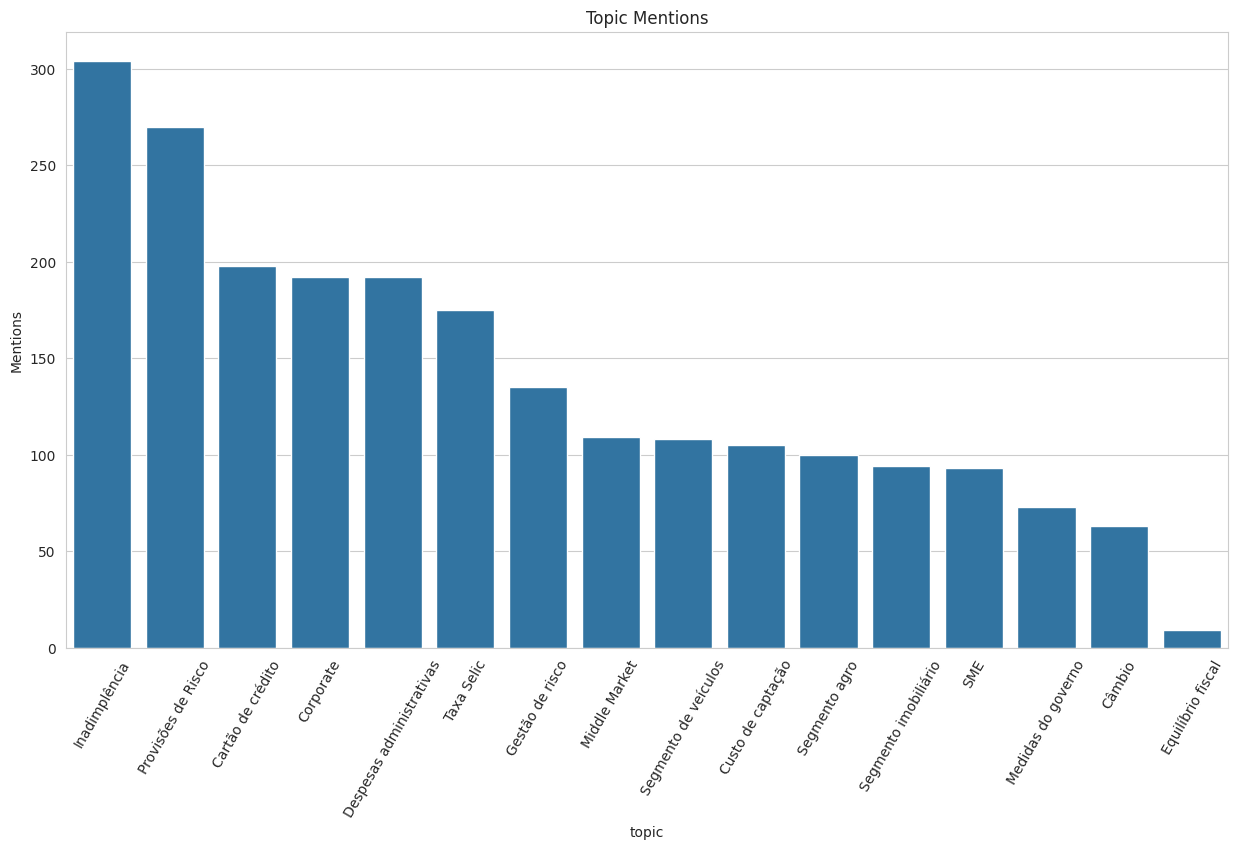

In [257]:
x = df_gpt.copy()
x['present'] = x['present'].apply(lambda x: 1 if x == 'Sim' else 0)
x['sentiment'] = x['sentiment'].apply(lambda x: 1 if x == 'Sim' else 0)
x = x.groupby('topic').agg({'present':'sum'}).reset_index().sort_values('present', ascending=False)

plt.figure(figsize=(15,8))
sns.barplot(data = x, x = 'topic', y = 'present')
plt.title(f'Topic Mentions')
plt.ylabel('Mentions')
plt.xticks(rotation=60)
plt.show()

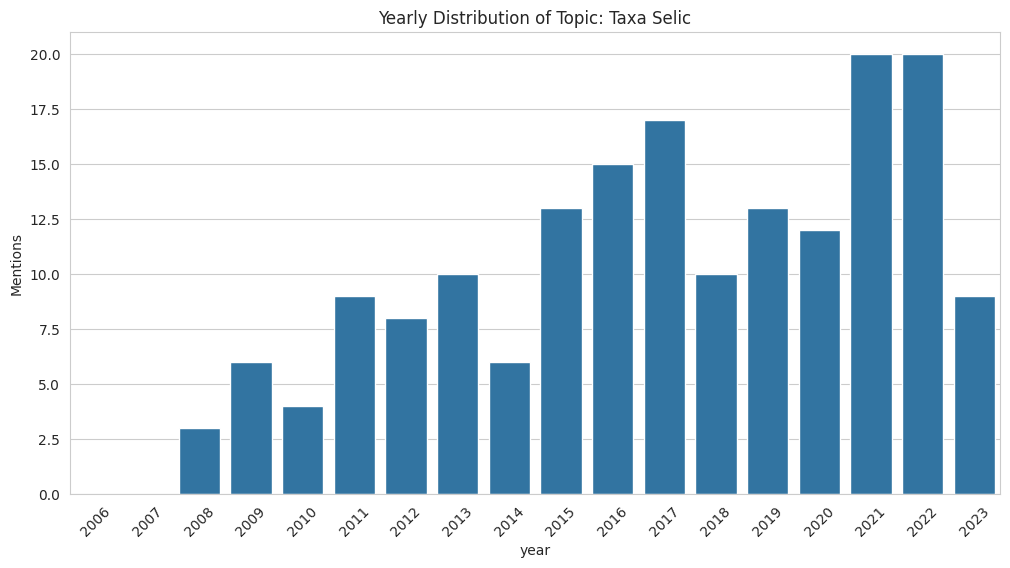

In [262]:
cat = 'Taxa Selic'
x = df_gpt[df_gpt['topic'] == cat].copy()
x['present'] = x['present'].apply(lambda x: 1 if x == 'Sim' else 0)
x['sentiment'] = x['sentiment'].apply(lambda x: 1 if x == 'Sim' else 0)

x = x.groupby(['topic','year']).agg({'present':'sum','sentiment':'sum'}).reset_index()

plt.figure(figsize=(12,6))
sns.barplot(x=x['year'],y=x['present'])

plt.title(f'Yearly Distribution of Topic: {cat}')
plt.ylabel('Mentions')
plt.xticks(rotation=45)
plt.show()

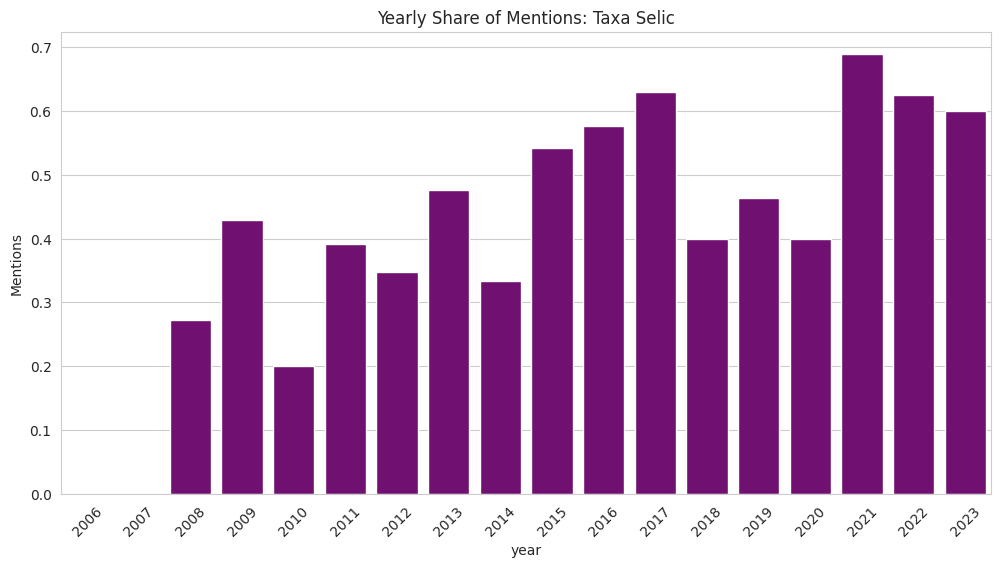

In [264]:
cat = 'Taxa Selic'
x = df_gpt[df_gpt['topic'] == cat].copy()
x['present'] = x['present'].apply(lambda x: 1 if x == 'Sim' else 0)
x['sentiment'] = x['sentiment'].apply(lambda x: 1 if x == 'Sim' else 0)

x = x.groupby(['topic','year']).agg({'present':'mean','sentiment':'sum'}).reset_index()

plt.figure(figsize=(12,6))
sns.barplot(x=x['year'],y=x['present'], color='purple')

plt.title(f'Yearly Share of Mentions: {cat}')
plt.ylabel('Mentions')
plt.xticks(rotation=45)
plt.show()

### Llama

#### Mentions

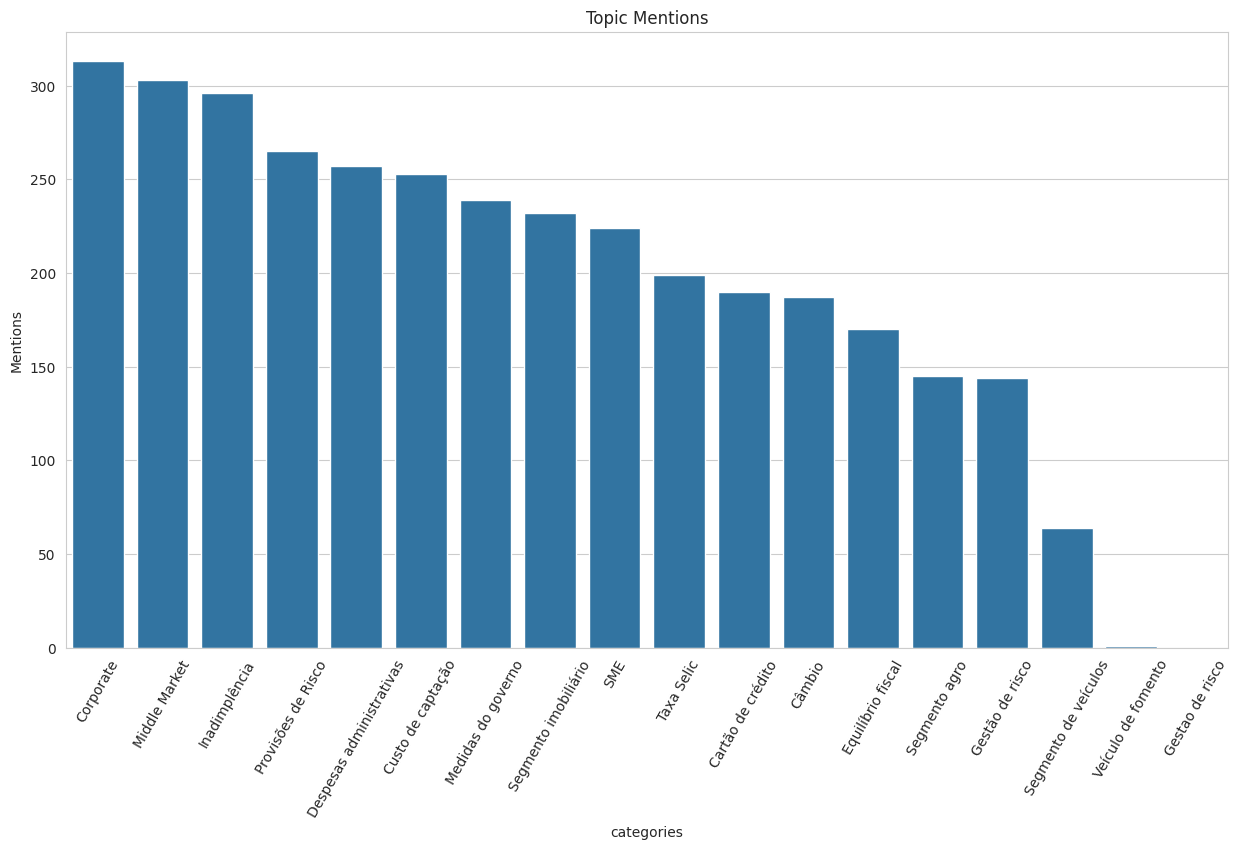

In [169]:
x = df_info.copy()
x['present'] = x['present'].apply(lambda x: 1 if x == 'Sim' else 0)
x['positive'] = x['positive'].apply(lambda x: 1 if x == 'Sim' else 0)
x = x.groupby('categories').agg({'present':'sum'}).reset_index().sort_values('present', ascending=False)

plt.figure(figsize=(15,8))
sns.barplot(data = x, x = 'categories', y = 'present')
plt.title(f'Topic Mentions')
plt.ylabel('Mentions')
plt.xticks(rotation=60)
plt.show()

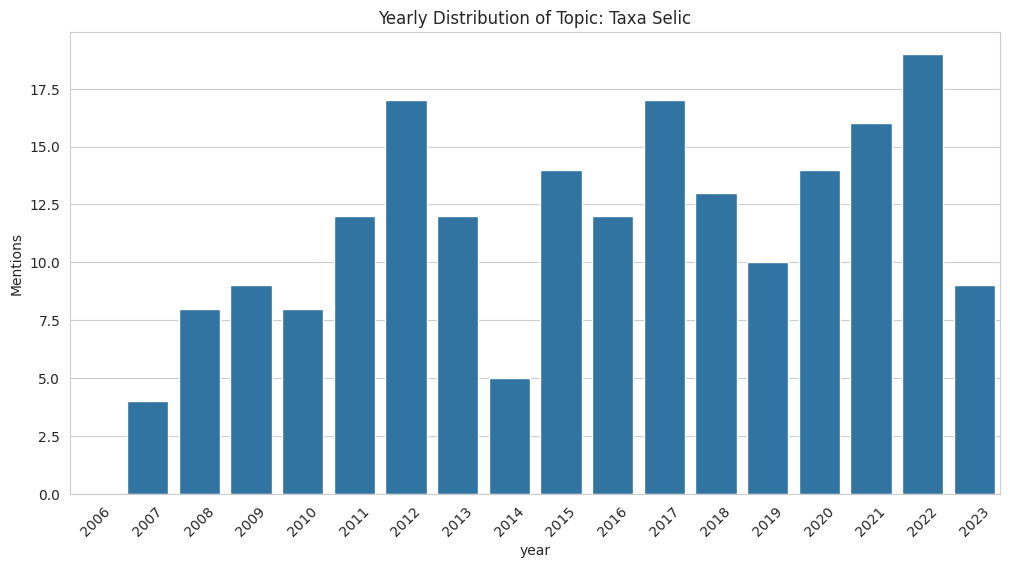

In [267]:
cat = 'Taxa Selic'
x = df_info[df_info['categories'] == cat].copy()
x['present'] = x['present'].apply(lambda x: 1 if x == 'Sim' else 0)
x['positive'] = x['positive'].apply(lambda x: 1 if x == 'Sim' else 0)

x = x.groupby(['categories','year']).agg({'present':'sum','positive':'sum'}).reset_index()

plt.figure(figsize=(12,6))
sns.barplot(x=x['year'],y=x['present'])

plt.title(f'Yearly Distribution of Topic: {cat}')
plt.ylabel('Mentions')
plt.xticks(rotation=45)
plt.show()

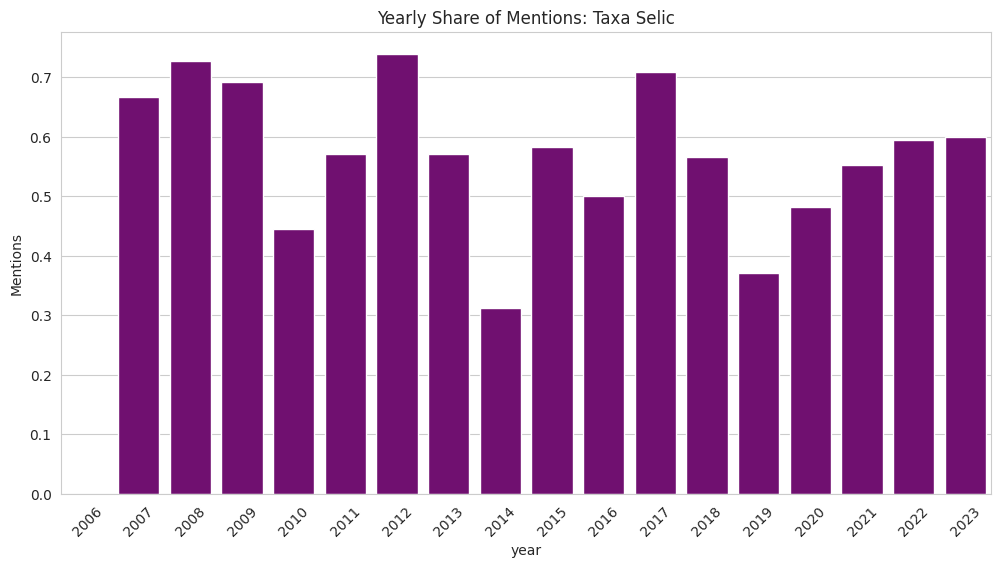

In [268]:
cat = 'Taxa Selic'
x = df_info[df_info['categories'] == cat].copy()
x['present'] = x['present'].apply(lambda x: 1 if x == 'Sim' else 0)
x['positive'] = x['positive'].apply(lambda x: 1 if x == 'Sim' else 0)

x = x.groupby(['categories','year']).agg({'present':'mean','positive':'sum'}).reset_index()

plt.figure(figsize=(12,6))
sns.barplot(x=x['year'],y=x['present'], color='purple')

plt.title(f'Yearly Share of Mentions: {cat}')
plt.ylabel('Mentions')
plt.xticks(rotation=45)
plt.show()

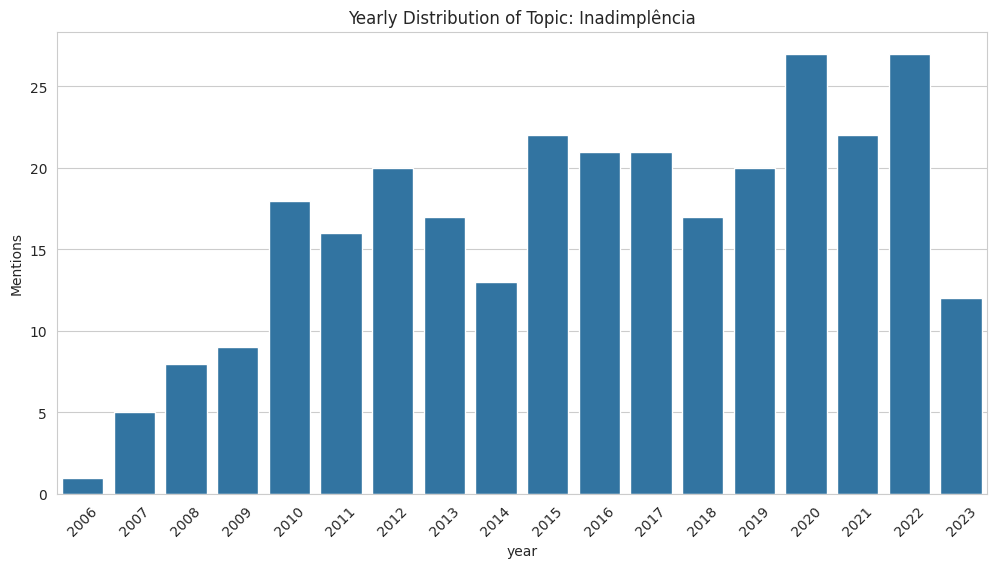

In [269]:
cat = 'Inadimplência'
x = df_info[df_info['categories'] == cat].copy()
x['present'] = x['present'].apply(lambda x: 1 if x == 'Sim' else 0)
x['positive'] = x['positive'].apply(lambda x: 1 if x == 'Sim' else 0)

x = x.groupby(['categories','year']).agg({'present':'sum','positive':'sum'}).reset_index()

plt.figure(figsize=(12,6))
sns.barplot(x=x['year'],y=x['present'])

plt.title(f'Yearly Distribution of Topic: {cat}')
plt.ylabel('Mentions')
plt.xticks(rotation=45)
plt.show()

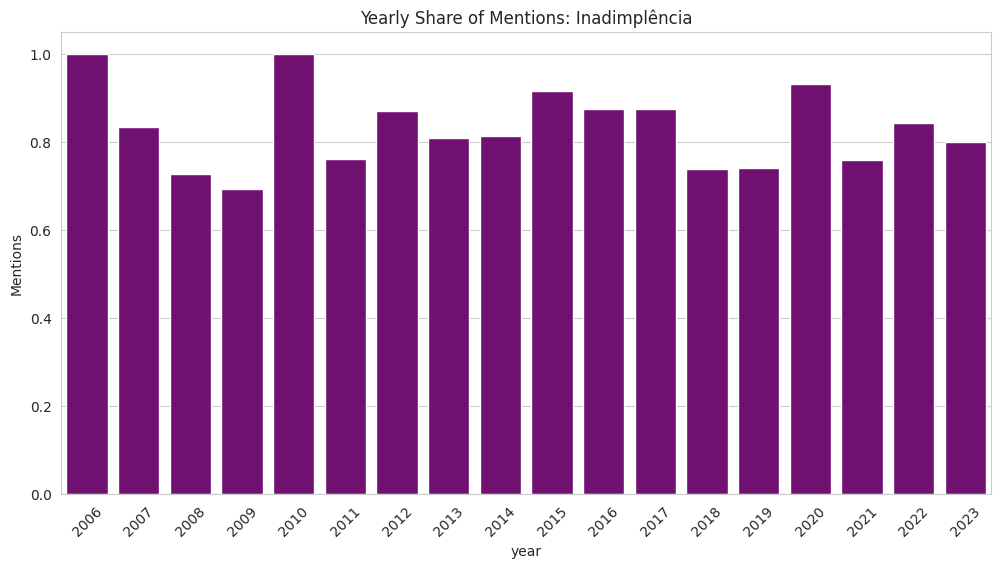

In [270]:
cat = 'Inadimplência'
x = df_info[df_info['categories'] == cat].copy()
x['present'] = x['present'].apply(lambda x: 1 if x == 'Sim' else 0)
x['positive'] = x['positive'].apply(lambda x: 1 if x == 'Sim' else 0)

x = x.groupby(['categories','year']).agg({'present':'mean','positive':'sum'}).reset_index()

plt.figure(figsize=(12,6))
sns.barplot(x=x['year'],y=x['present'], color='purple')

plt.title(f'Yearly Share of Mentions: {cat}')
plt.ylabel('Mentions')
plt.xticks(rotation=45)
plt.show()

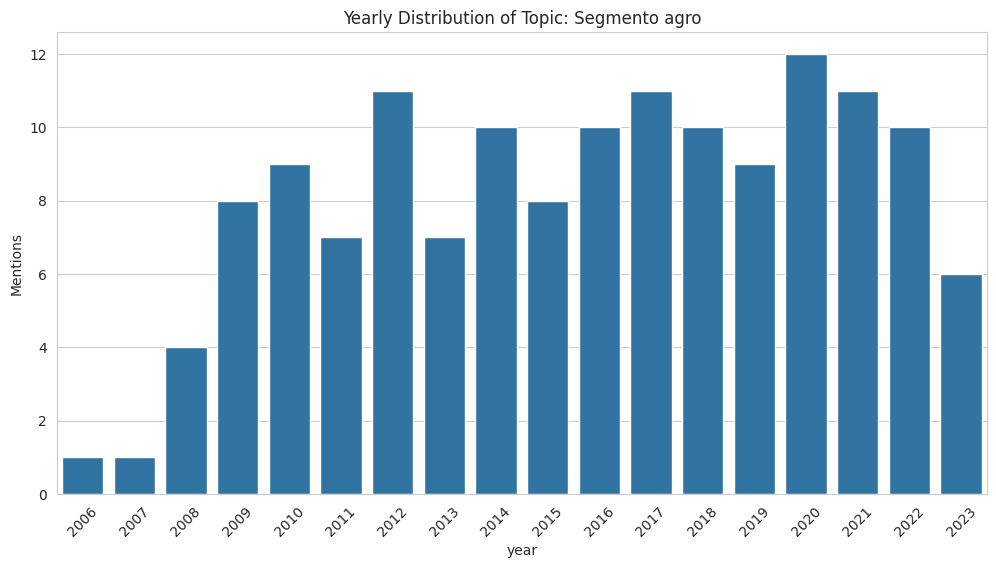

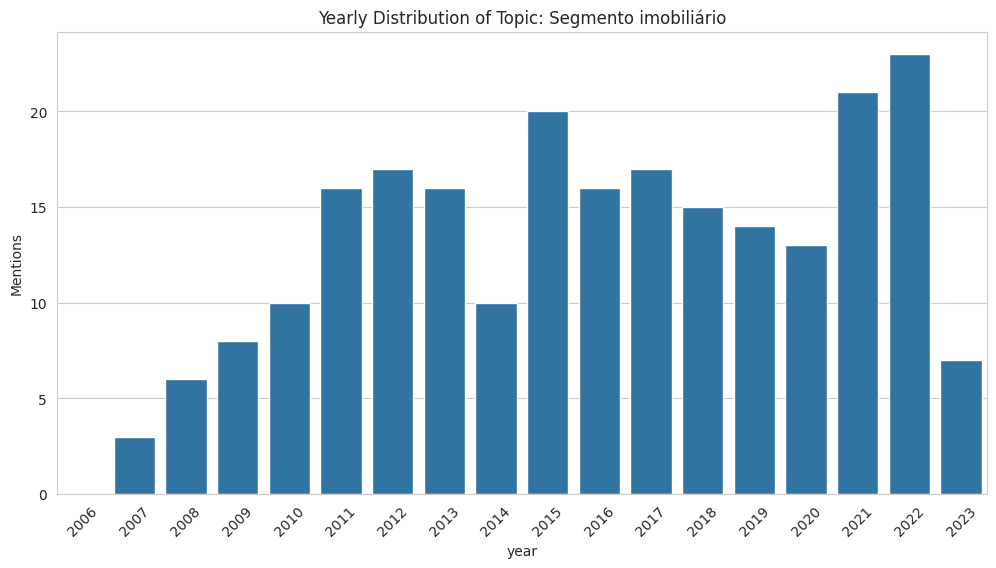

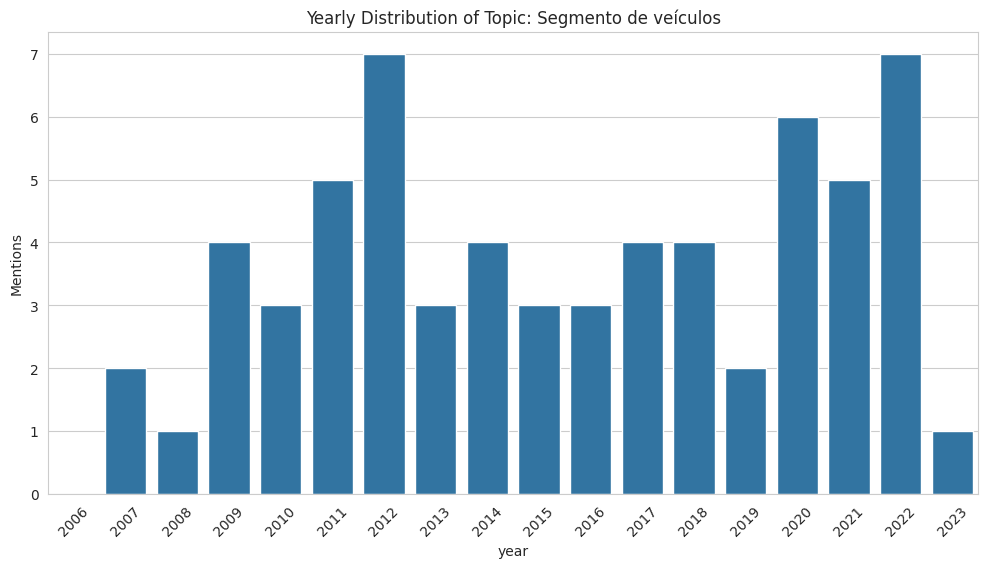

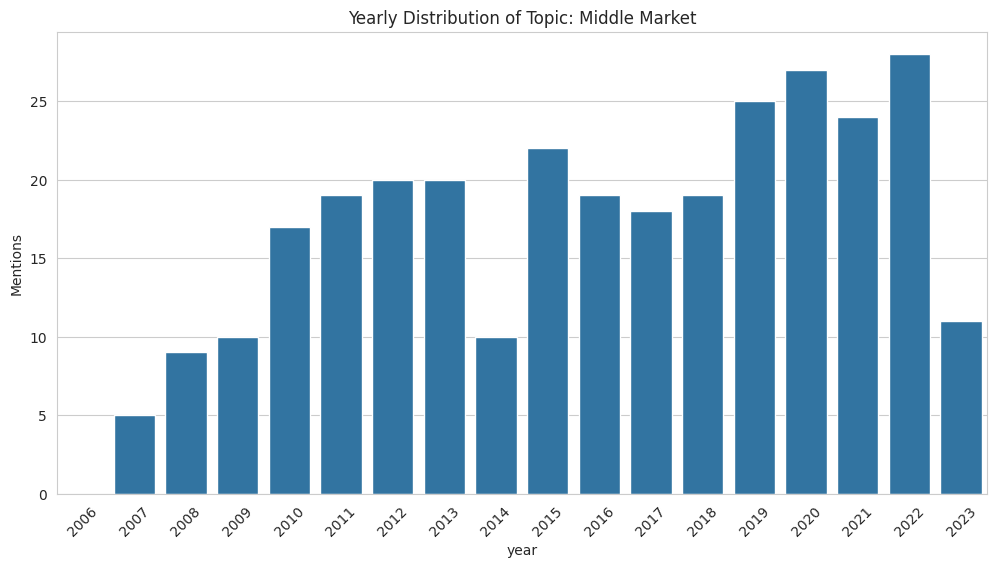

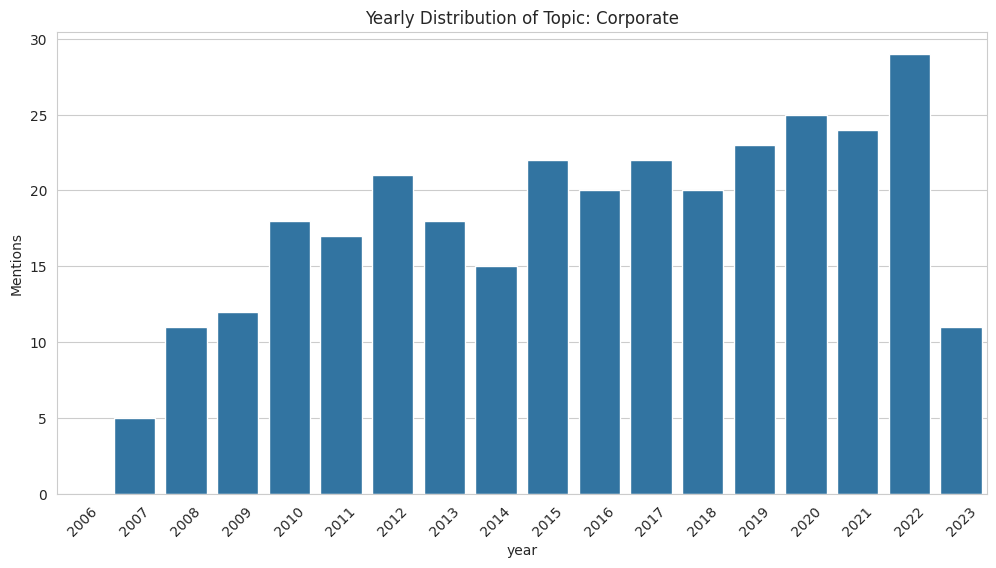

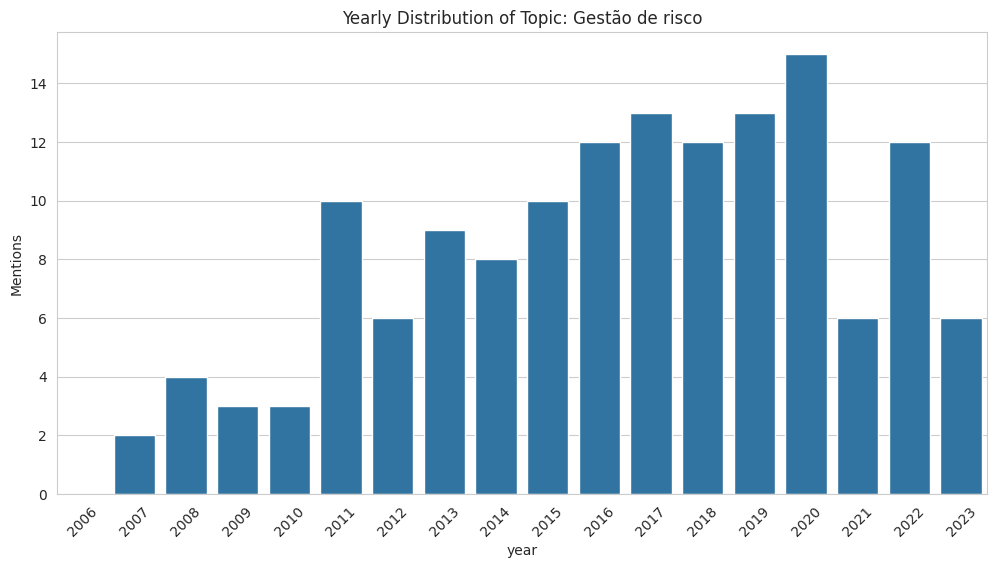

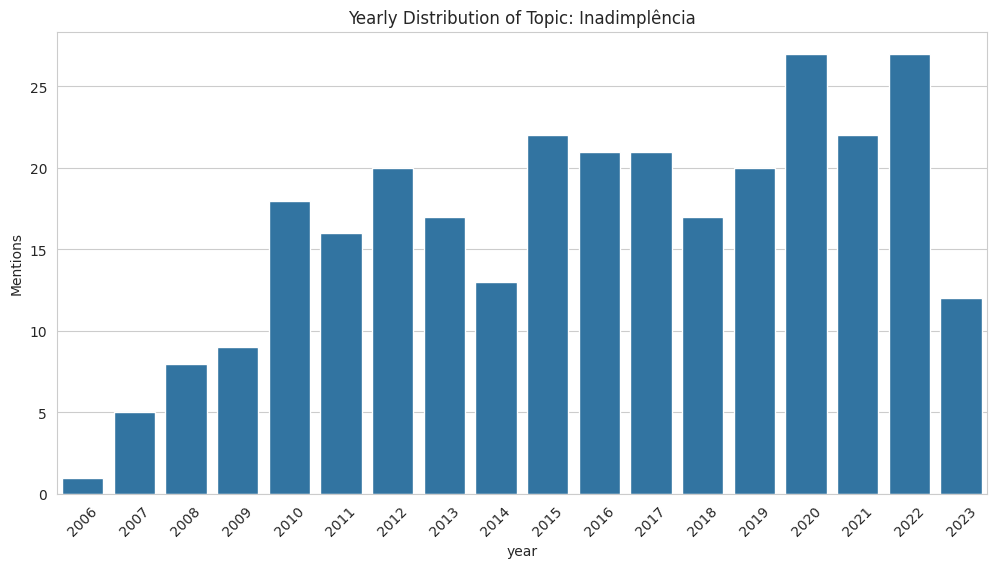

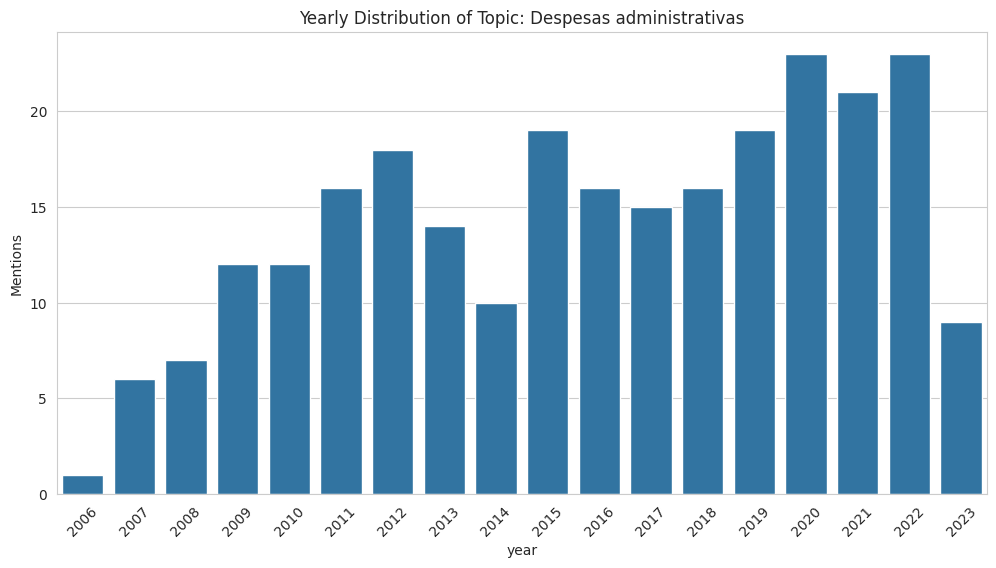

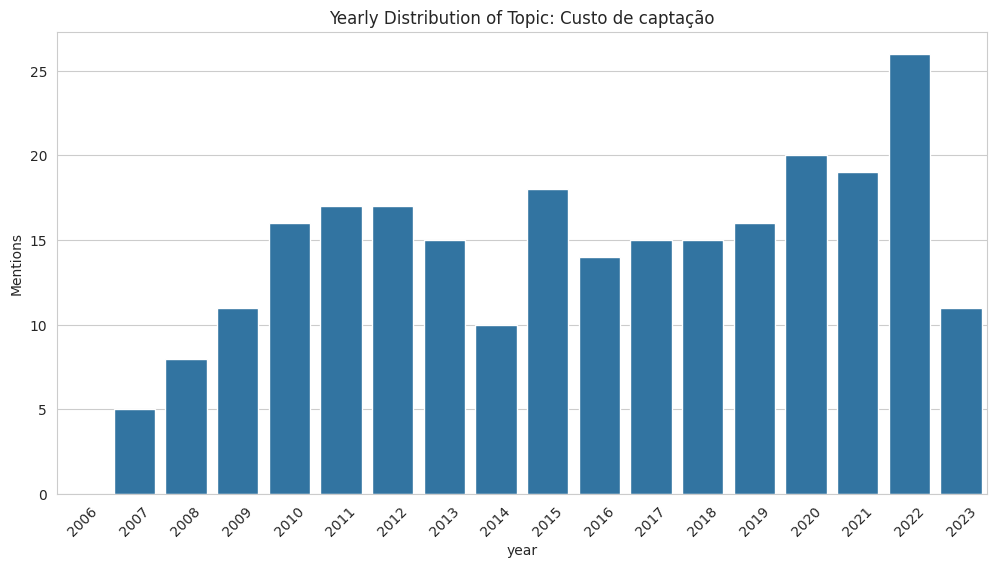

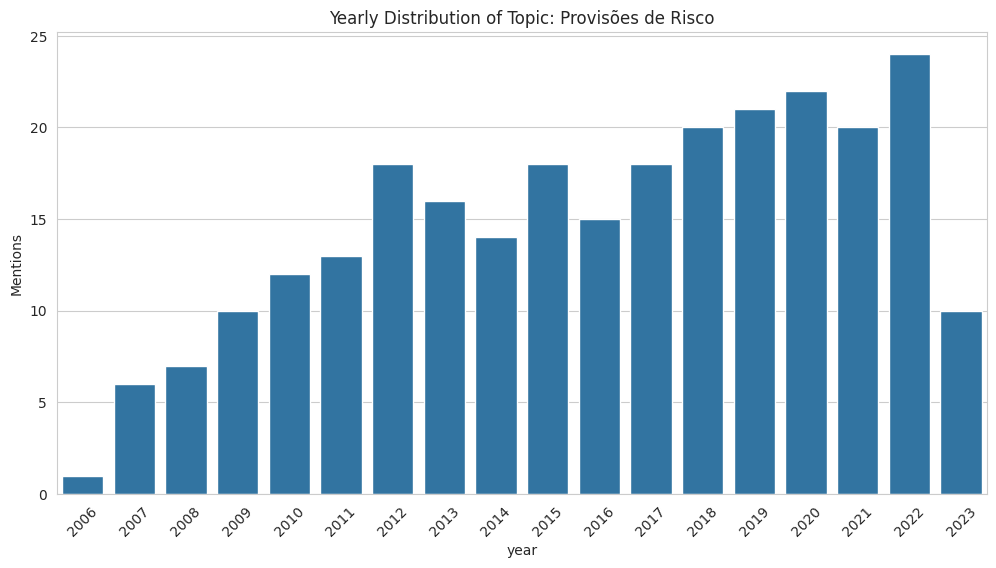

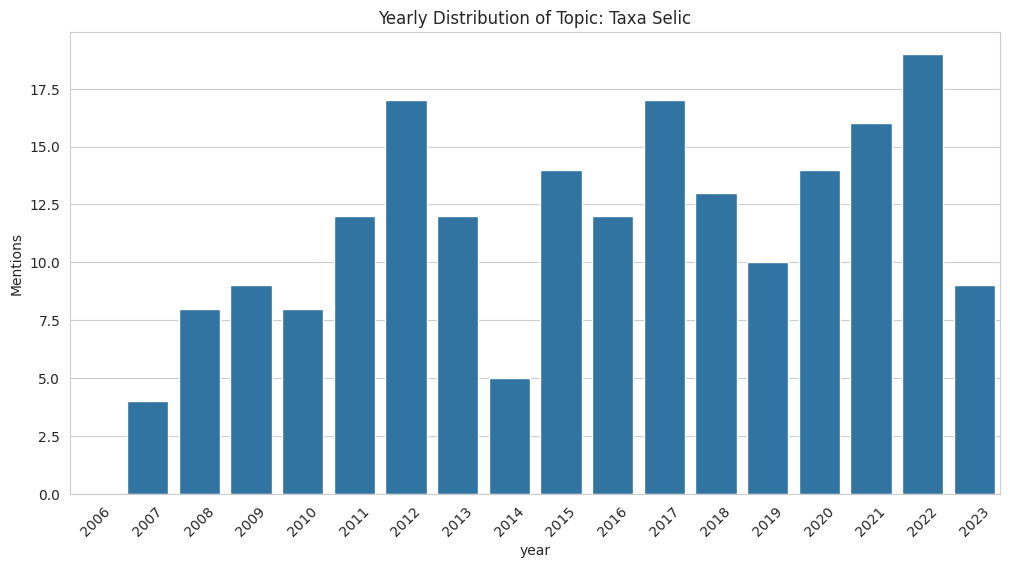

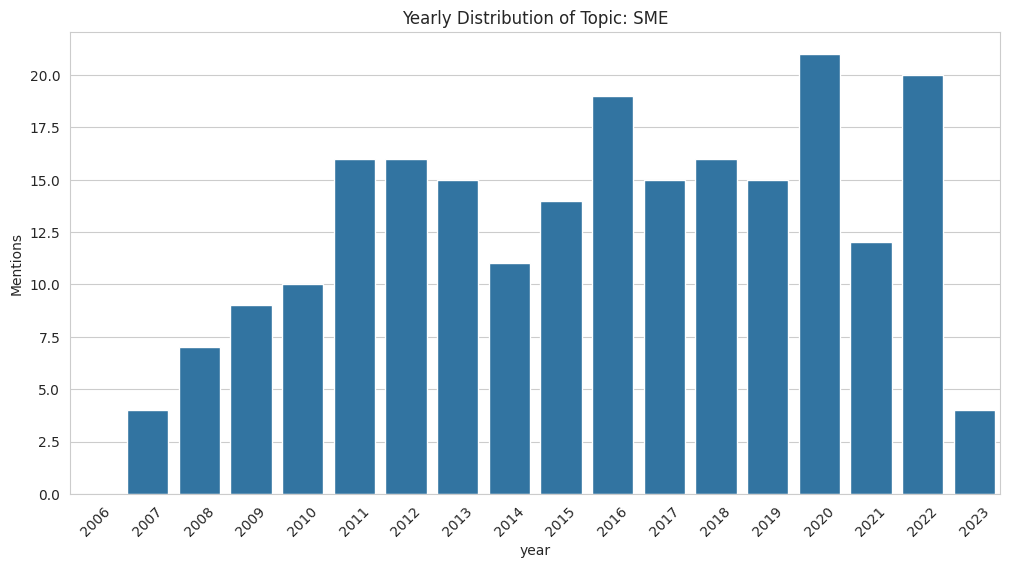

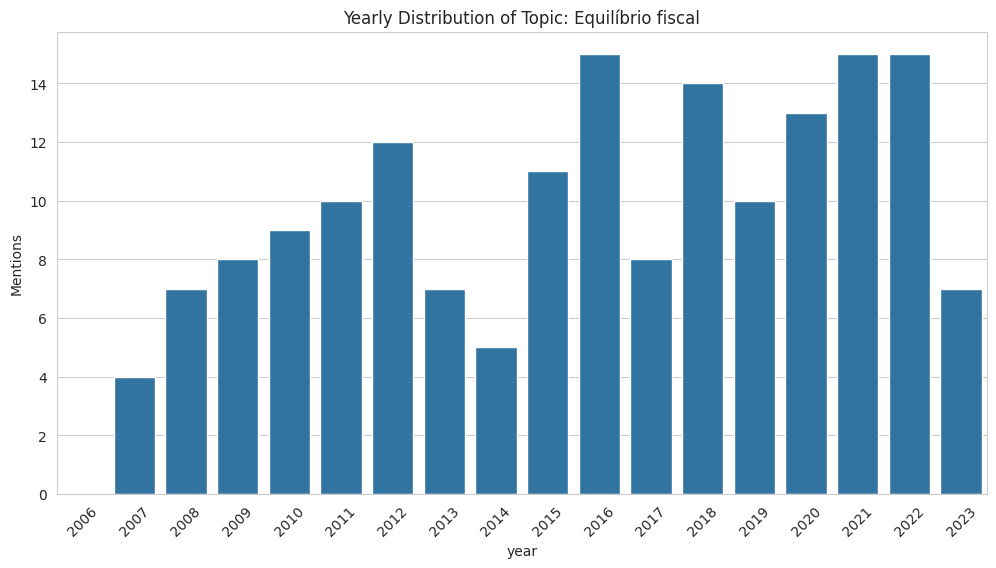

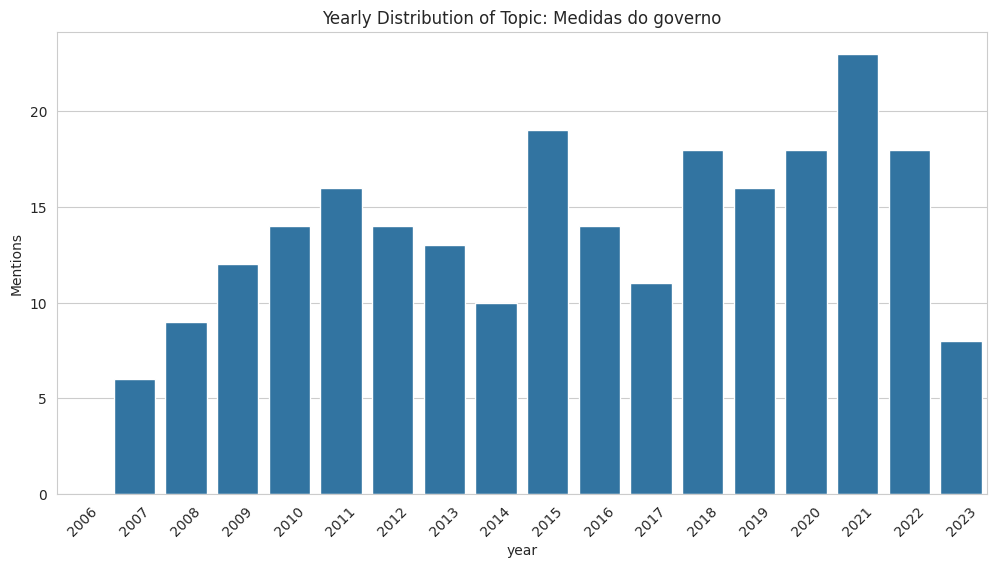

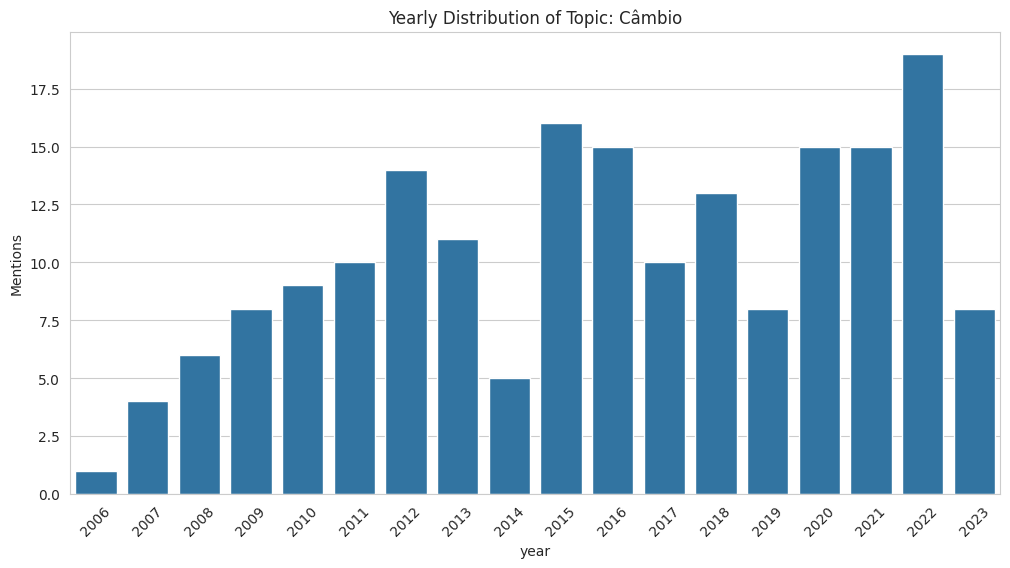

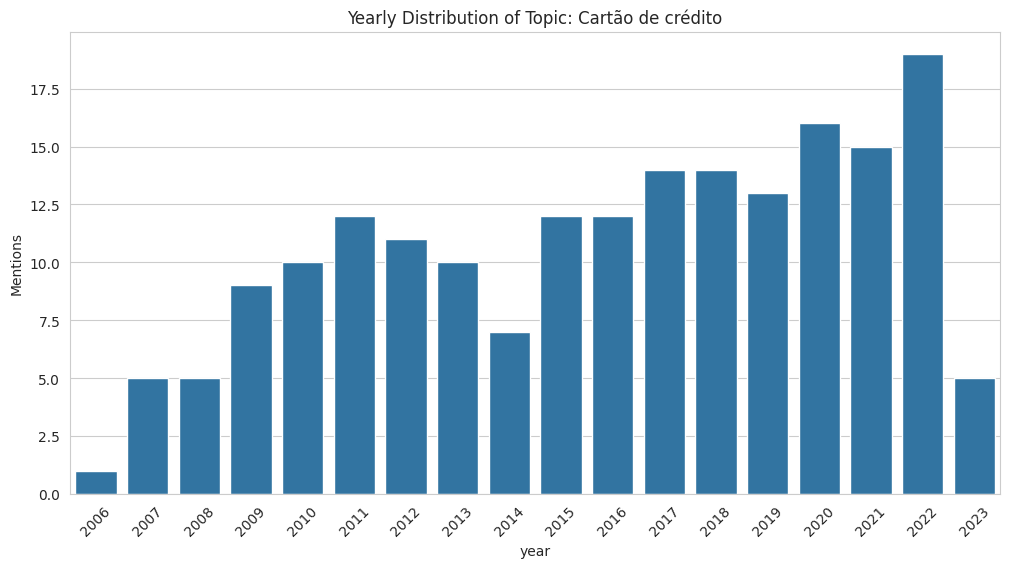

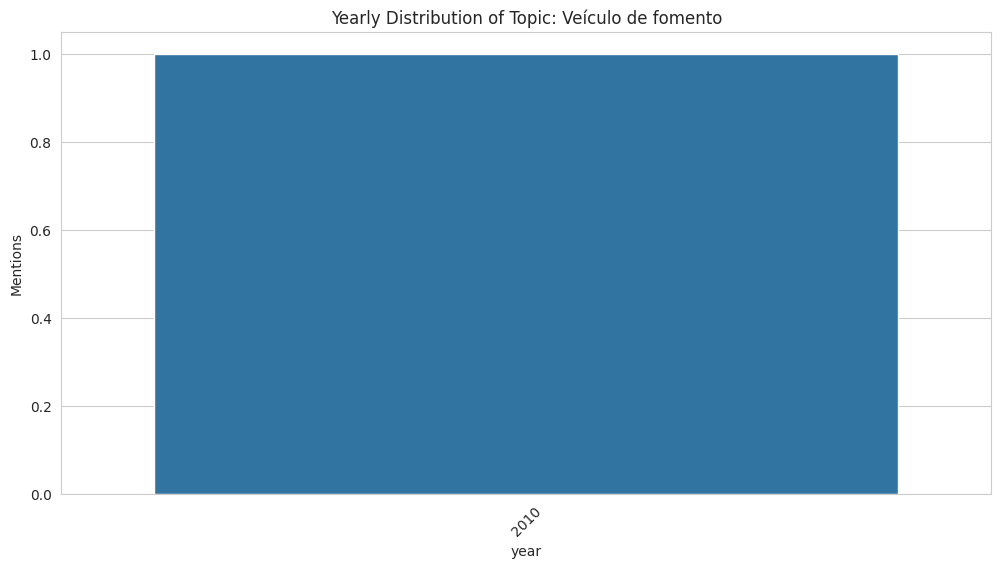

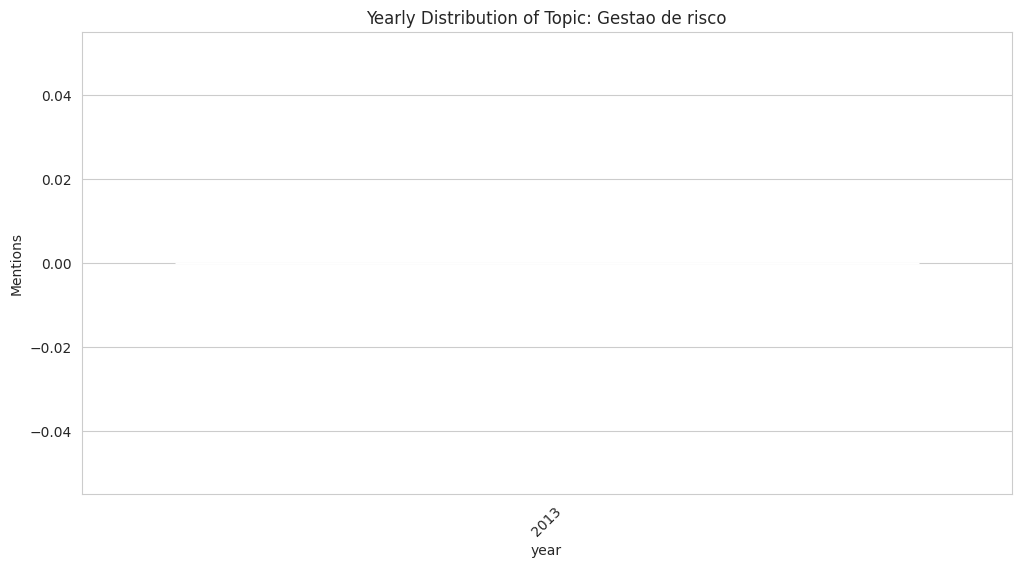

In [172]:
for cat in df_info['categories'].unique():
  x = df_info[df_info['categories'] == cat].copy()
  x['present'] = x['present'].apply(lambda x: 1 if x == 'Sim' else 0)
  x['positive'] = x['positive'].apply(lambda x: 1 if x == 'Sim' else 0)

  x = x.groupby(['categories','year']).agg({'present':'sum','positive':'sum'}).reset_index()

  plt.figure(figsize=(12,6))
  sns.barplot(x=x['year'],y=x['present'])

  plt.title(f'Yearly Distribution of Topic: {cat}')
  plt.ylabel('Mentions')
  plt.xticks(rotation=45)
  plt.show()

#### Sentiment

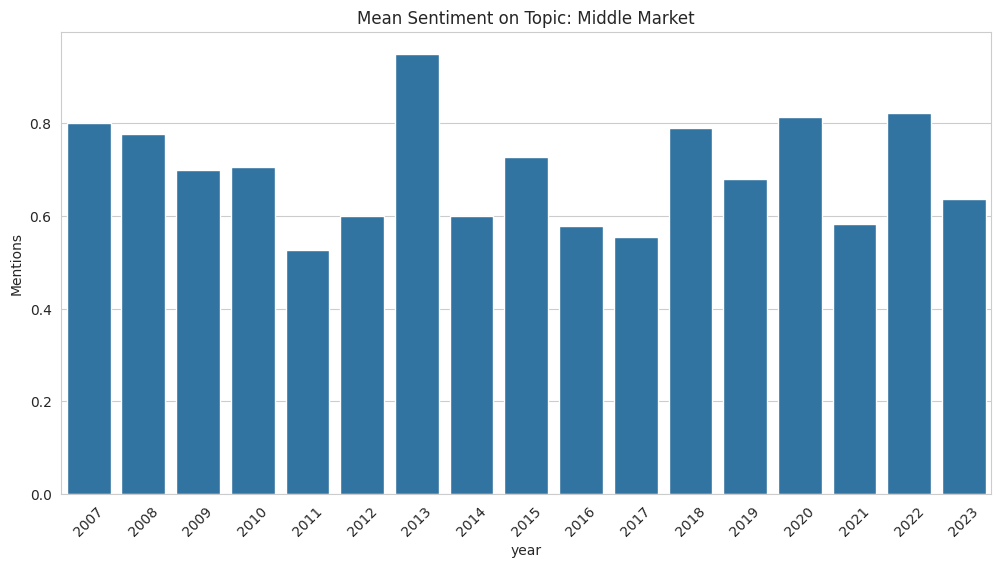

In [185]:
cat = 'Middle Market'
x = df_info[df_info['categories'] == cat].copy()
x = x[x['present'] == 'Sim']
x['present'] = x['present'].apply(lambda x: 1 if x == 'Sim' else 0)
x['positive'] = x['positive'].apply(lambda x: 1 if x == 'Sim' else 0)

x = x.groupby(['categories','year']).agg({'positive':'mean'}).reset_index()

plt.figure(figsize=(12,6))
sns.barplot(x=x['year'],y=x['positive'])

plt.title(f'Mean Sentiment on Topic: {cat}')
plt.ylabel('Mentions')
plt.xticks(rotation=45)
plt.show()

In [203]:
df_info['bank'].unique()

array(['brsr', 'bbdc', 'itub', 'bbas', 'sanb', 'abcb', 'bmgb', 'nu',
       'bpan', 'prbc'], dtype=object)

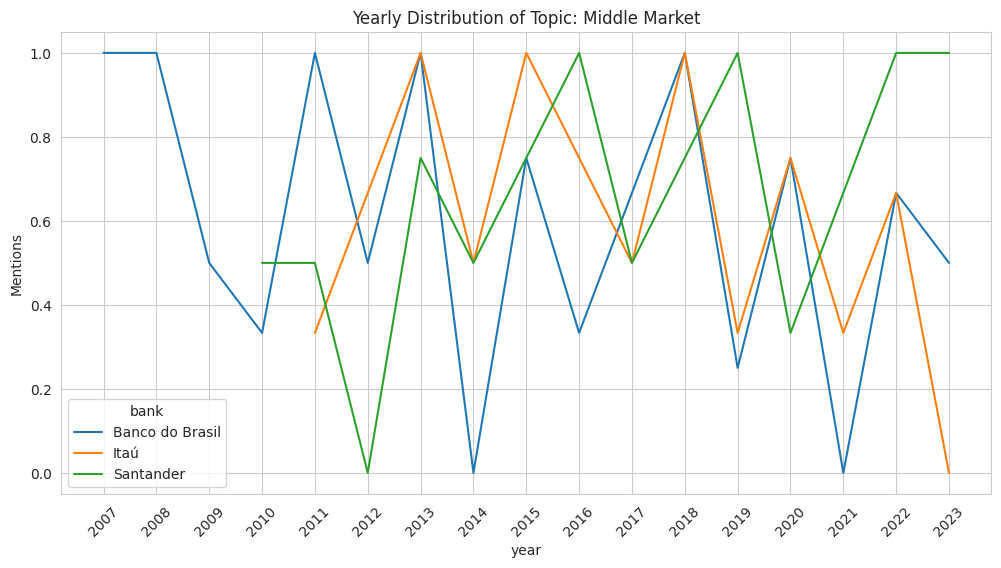

In [204]:
bank_mapping = {'itub':'Itaú',
                'bbas':'Banco do Brasil',
                'sanb':'Santander'}

cat = 'Middle Market'
x = df_info[df_info['categories'] == cat].copy()
x = x[x['bank'].isin(['itub','bbas','sanb'])]
x['bank'] = x['bank'].replace(bank_mapping)

x = x[x['present'] == 'Sim']
x['present'] = x['present'].apply(lambda x: 1 if x == 'Sim' else 0)
x['positive'] = x['positive'].apply(lambda x: 1 if x == 'Sim' else 0)

x = x.groupby(['categories','bank','year']).agg({'positive':'mean'}).reset_index()

plt.figure(figsize=(12,6))
sns.lineplot(x=x['year'],y=x['positive'],hue=x['bank'])

plt.title(f'Yearly Distribution of Topic: {cat}')
plt.ylabel('Mentions')
plt.xticks(rotation=45)
plt.show()

#### Bank Specific

In [310]:
df_info['bank'].unique()

array(['brsr', 'bbdc', 'itub', 'bbas', 'sanb', 'abcb', 'bmgb', 'nu',
       'bpan', 'prbc'], dtype=object)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
 [Text(0, 0, 'Corporate'),
  Text(1, 0, 'Provisões de Risco'),
  Text(2, 0, 'Inadimplência'),
  Text(3, 0, 'Despesas administrativas'),
  Text(4, 0, 'Middle Market'),
  Text(5, 0, 'Segmento imobiliário'),
  Text(6, 0, 'Custo de captação'),
  Text(7, 0, 'Medidas do governo'),
  Text(8, 0, 'Taxa Selic'),
  Text(9, 0, 'Equilíbrio fiscal'),
  Text(10, 0, 'Gestão de risco'),
  Text(11, 0, 'SME'),
  Text(12, 0, 'Cartão de crédito'),
  Text(13, 0, 'Câmbio'),
  Text(14, 0, 'Segmento agro'),
  Text(15, 0, 'Segmento de veículos')])

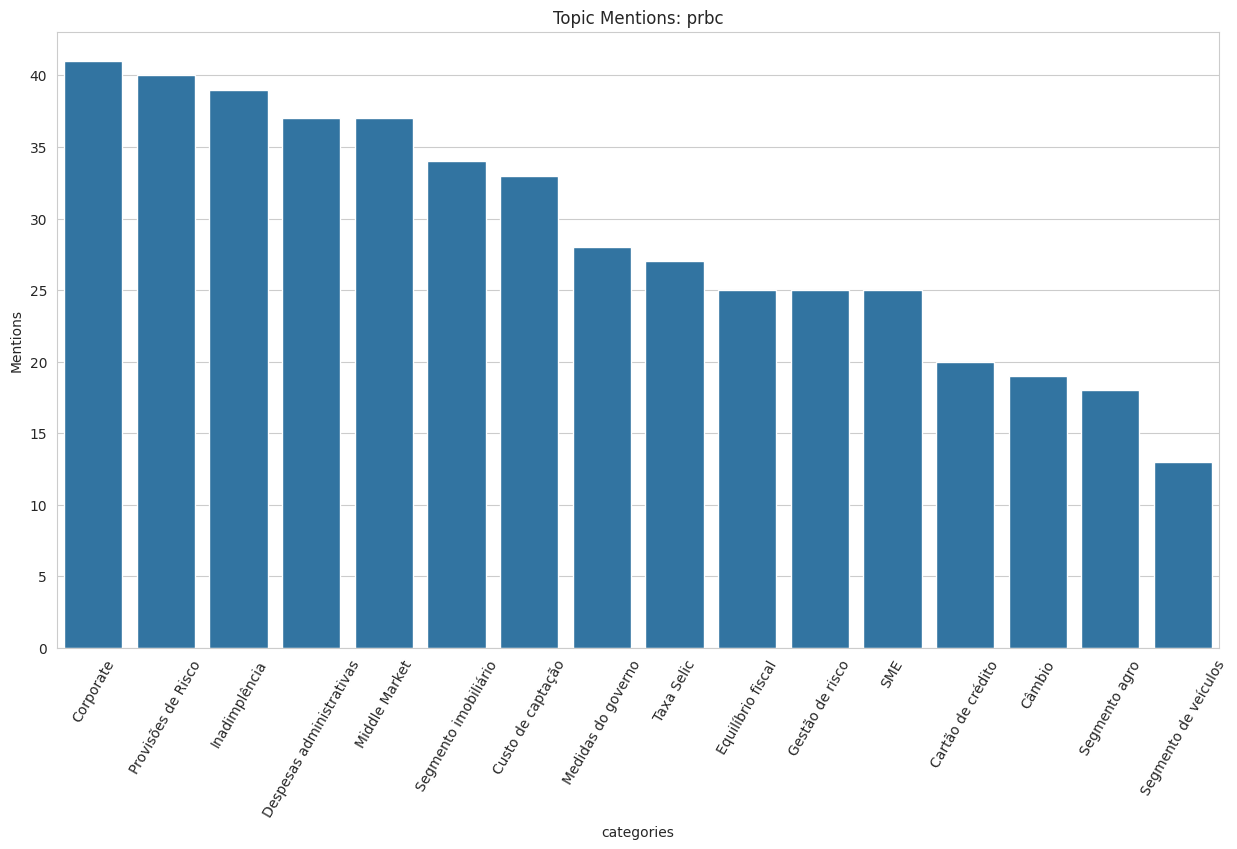

In [312]:
bank = 'prbc'
x = df_info[df_info['bank'] == 'itub'].copy()
x['present'] = x['present'].apply(lambda x: 1 if x == 'Sim' else 0)
x['positive'] = x['positive'].apply(lambda x: 1 if x == 'Sim' else 0)
x = x.groupby('categories').agg({'present':'sum'}).reset_index().sort_values('present', ascending=False)

plt.figure(figsize=(15,8))
sns.barplot(data = x, x = 'categories', y = 'present')
plt.title(f'Topic Mentions: {bank}')
plt.ylabel('Mentions')
plt.xticks(rotation=60)

In [195]:
path_cotacoes = '/content/drive/MyDrive/Portfolio Projects/Mestrado/Cotações'
cotacoes_lis = os.listdir(path_cotacoes)
total_path_cotacoes = os.path.join(path_cotacoes, cotacoes_lis[0])
print(total_path_cotacoes)
df_cotacoes_bb = pd.read_csv(total_path_cotacoes, sep=';')

df_cotacoes_bb.columns = df_cotacoes_bb.iloc[0]
df_cotacoes_bb = df_cotacoes_bb[1:]
df_cotacoes_bb.reset_index(drop=True, inplace=True)
df_cotacoes_bb['Abertura'] = df_cotacoes_bb['Abertura'].apply(lambda x: x.replace(',','.'))

# Convert the 'Date' column
df_cotacoes_bb['Data'] = pd.to_datetime(df_cotacoes_bb['Data'], format='%d/%m/%Y')
# Define the first days of each quarter
first_days_of_quarters = df_cotacoes_bb['Data'].dt.is_quarter_start
# Filter the DataFrame to keep only the first day of each quarter
df_cotacoes_bb = df_cotacoes_bb[first_days_of_quarters]

df_cotacoes_bb['Abertura'] = df_cotacoes_bb['Abertura'].astype(float)
df_cotacoes_bb.head()

/content/drive/MyDrive/Portfolio Projects/Mestrado/Cotações/Histórico de Cotações-20241121 - BB.csv


,Data,Abertura,Máxima,Mínima,Fechado,Média,Variação,Volume,Quantidade de Ações,Negócios
249,2022-07-01,13.54,"13,66","13,44","13,58","13,53","-0,68 %",275857792,8347800,26395
311,2022-04-01,14.01,"14,06","13,75","13,9","13,92","-0,05 %",906718080,26102900,41542
434,2021-10-01,11.14,"11,36","11,09","11,34","11,28","2,24 %",274470016,9342400,19650
498,2021-07-01,12.18,"12,23","11,99","12,02","12,06","-1,05 %",329410176,10320700,22547
560,2021-04-01,11.46,"11,47","11,13","11,15","11,21","-1,64 %",389320992,12932500,41140


<Figure size 1500x600 with 0 Axes>

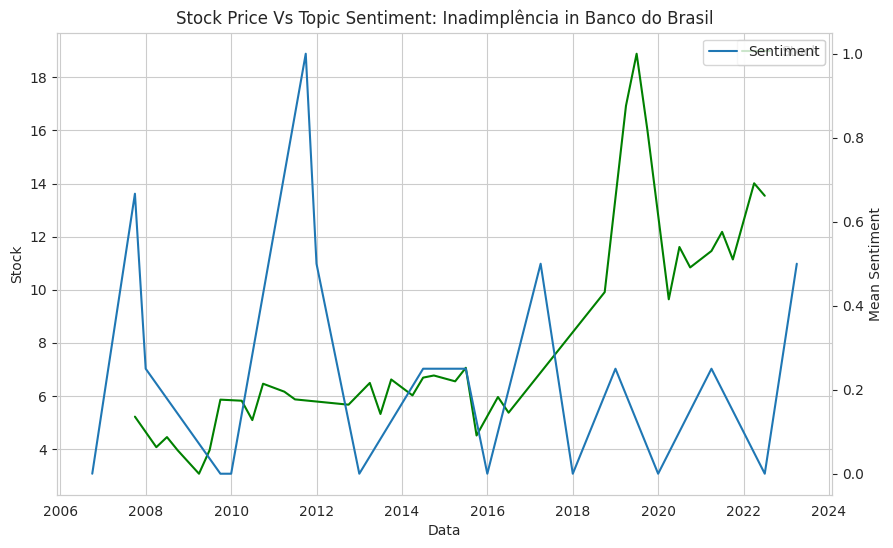

In [306]:
cat = 'Inadimplência'
bank = 'Banco do Brasil'
x = df_info[df_info['bank'] == 'bbas'].copy()
x = x[x['categories'] == cat].copy()

x['present'] = x['present'].apply(lambda x: 1 if x == 'Sim' else 0)
x['positive'] = x['positive'].apply(lambda x: 1 if x == 'Sim' else 0)

x['Data'] = x.apply(lambda x: '01/01' if x['trimester'] == '1' else ('01/04' if x['trimester'] == '2' else ('01/07' if x['trimester'] == '3' else '01/10')), axis=1) + '/' + x['year'].astype(str)
x['Data'] = pd.to_datetime(x['Data'], format='%d/%m/%Y')

x = x.groupby('year').agg({'Data':'first','positive':'mean'}).reset_index()#.sort_values('positive', ascending=False)

plt.figure(figsize=(15, 6))
fig, ax1 = plt.subplots(figsize=(10, 6))

sns.lineplot(x = df_cotacoes_bb['Data'], y = df_cotacoes_bb['Abertura'], ax=ax1, color = 'green', label = 'Stock')

ax2 = ax1.twinx()
sns.lineplot(x = x['Data'], y = x['positive'], ax = ax2, label = 'Sentiment')

#ax2.yaxis.set_label_coords(0.1, 0.5)
ax2.grid(False)

plt.xticks(rotation=70)
plt.title(f'Stock Price Vs Topic Sentiment: {cat} in {bank}')
ax1.set_ylabel('Stock')
ax2.set_ylabel('Mean Sentiment')
plt.show()

## Model Comparison

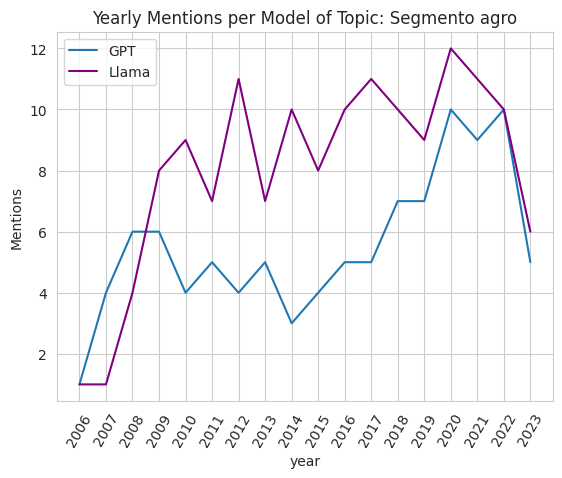

In [289]:
cat = df_gpt['topic'].unique()[0]
x = df_gpt[df_gpt['topic'] == cat].copy()
y = df_info[df_info['categories'] == cat].copy()
y.rename(columns={'categories':'topic','positive':'sentiment'}, inplace=True)

x['present'] = x['present'].apply(lambda x: 1 if x == 'Sim' else 0)
x['sentiment'] = x['sentiment'].apply(lambda x: 1 if x == 'Sim' else 0)
y['present'] = y['present'].apply(lambda x: 1 if x == 'Sim' else 0)
y['sentiment'] = y['sentiment'].apply(lambda x: 1 if x == 'Sim' else 0)

x = x.groupby('year').agg({'present':'sum'}).reset_index()
y = y.groupby('year').agg({'present':'sum'}).reset_index()

sns.lineplot(y = x['present'], x = x['year'],label='GPT')
sns.lineplot(y = y['present'], x = y['year'], color='purple', label = 'Llama')
plt.xticks(rotation=60)
plt.title(f'Yearly Mentions per Model of Topic: {cat}')
plt.ylabel('Mentions')
plt.show()

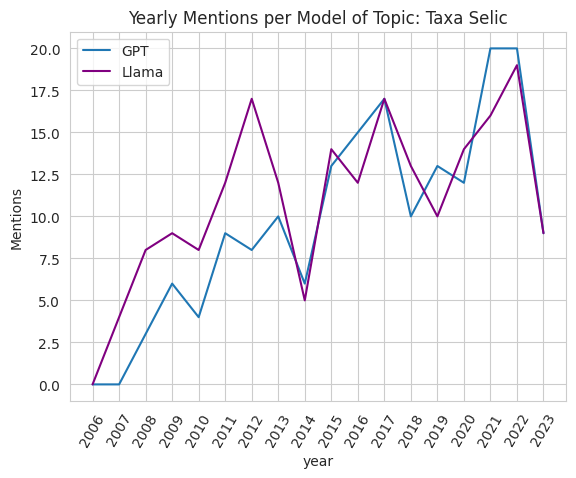

In [293]:
cat = 'Taxa Selic'
x = df_gpt[df_gpt['topic'] == cat].copy()
y = df_info[df_info['categories'] == cat].copy()
y.rename(columns={'categories':'topic','positive':'sentiment'}, inplace=True)

x['present'] = x['present'].apply(lambda x: 1 if x == 'Sim' else 0)
x['sentiment'] = x['sentiment'].apply(lambda x: 1 if x == 'Sim' else 0)
y['present'] = y['present'].apply(lambda x: 1 if x == 'Sim' else 0)
y['sentiment'] = y['sentiment'].apply(lambda x: 1 if x == 'Sim' else 0)

x = x.groupby('year').agg({'present':'sum'}).reset_index()
y = y.groupby('year').agg({'present':'sum'}).reset_index()

sns.lineplot(y = x['present'], x = x['year'],label='GPT')
sns.lineplot(y = y['present'], x = y['year'], color='purple', label = 'Llama')
plt.xticks(rotation=60)
plt.title(f'Yearly Mentions per Model of Topic: {cat}')
plt.ylabel('Mentions')
plt.show()

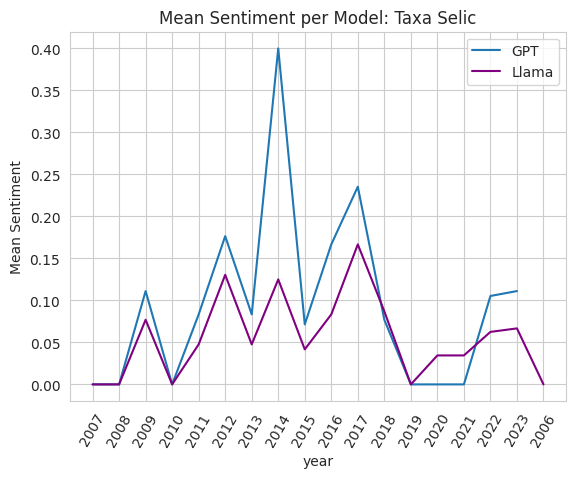

In [297]:
cat = 'Taxa Selic'
x = df_gpt[df_gpt['topic'] == cat].copy()
y = df_info[df_info['categories'] == cat].copy()
y.rename(columns={'categories':'topic','positive':'sentiment'}, inplace=True)

x = x[x['present'] == 'Sim'].copy()
x = y[y['present'] == 'Sim'].copy()
x['present'] = x['present'].apply(lambda x: 1 if x == 'Sim' else 0)
x['sentiment'] = x['sentiment'].apply(lambda x: 1 if x == 'Sim' else 0)
y['present'] = y['present'].apply(lambda x: 1 if x == 'Sim' else 0)
y['sentiment'] = y['sentiment'].apply(lambda x: 1 if x == 'Sim' else 0)

x = x.groupby('year').agg({'sentiment':'mean'}).reset_index()
y = y.groupby('year').agg({'sentiment':'mean'}).reset_index()

sns.lineplot(y = x['sentiment'], x = x['year'],label='GPT')
sns.lineplot(y = y['sentiment'], x = y['year'], color='purple', label = 'Llama')
plt.xticks(rotation=60)
plt.title(f'Mean Sentiment per Model: {cat}')
plt.ylabel('Mean Sentiment')
plt.show()